In [1]:
# !unzip '/content/Phase2.zip'

## Imports

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-4
NUM_CLASSES = 3
CLASSES = ['Gaussian', 'Periodic', 'Salt']
N_CHANNELS = 3

In [4]:
base_dir = './content/DataSet2'

In [ ]:
def plt_figure(images: list, titles: list, cmap='gray', rows=1, columns=1, w=5, h=5):
    fig = plt.figure(figsize=(w, h))
    count = 1
    for image, title in zip(images, titles):
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
        plt.title(title)

In [5]:
import cv2

# def convert_to_ms(image):
#     image = np.fft.fftshift(np.fft.fft2(image))
#     image = 20*np.log(np.abs(image))
#     return image

def convert_to_ms(image):
    if(N_CHANNELS==3):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.fft.fftshift(np.fft.fft2(image))
    image = 20*(np.log(np.abs(image)))
    image = (image / np.max(image))*255
    image = np.uint8(np.round(image))
    if(N_CHANNELS==3):
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image = image/255
    return image

In [6]:
def read_images(files):
    if os.path.isfile(files):
        if(N_CHANNELS==1):
            return cv2.resize(cv2.imread(files, cv2.IMREAD_GRAYSCALE), dsize=(IMAGE_HEIGHT,IMAGE_WIDTH))
        else:
            return cv2.resize(cv2.imread(files), dsize=(IMAGE_HEIGHT,IMAGE_WIDTH))
    arr = []
    for file in files:
        if(N_CHANNELS==1):
            arr.append(cv2.resize(cv2.imread(file, cv2.IMREAD_GRAYSCALE), dsize=(IMAGE_HEIGHT,IMAGE_WIDTH)))
        else:
            arr.append(cv2.resize(cv2.imread(file), dsize=(IMAGE_HEIGHT,IMAGE_WIDTH)))
    return np.array(arr)

In [ ]:
import keras.utils as image

def load_test_image(path):
    img = image.load_img(path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

In [7]:
data = pd.read_excel('./content/Labels.xlsx')
data.head()

,Denoise Image,Noise Type,Noisy Image
0,Without-Noise/cast_def_0_0.jpeg,Gaussian,With-Noise/cast_def_0_0.jpeg
1,Without-Noise/cast_def_0_2.jpeg,Gaussian,With-Noise/cast_def_0_2.jpeg
2,Without-Noise/cast_def_0_22.jpeg,Gaussian,With-Noise/cast_def_0_22.jpeg
3,Without-Noise/cast_def_0_25.jpeg,Gaussian,With-Noise/cast_def_0_25.jpeg
4,Without-Noise/cast_def_0_33.jpeg,Gaussian,With-Noise/cast_def_0_33.jpeg


In [8]:
all_data = {'data': np.array([convert_to_ms(read_images(os.path.join(base_dir,file))) for file in data['Noisy Image']], dtype=np.float32),
              'labels': np.array([0 if t==CLASSES[0] else 1 if t==CLASSES[1] else 2 for t in data['Noise Type']], dtype=np.int8),
              'names': np.array([name for name in data['Noisy Image']])}
print('data:', all_data['data'].shape, 'type', type(all_data['data'][0,0,0,0]))
print('labels:', all_data['labels'].shape, 'type', type(all_data['labels'][0]))

data: (1250, 224, 224, 3) type <class 'numpy.float32'>
labels: (1250,) type <class 'numpy.int8'>


In [ ]:
data = pd.DataFrame({
    "images" : [os.path.join(base_dir, dir) for dir in data['Noisy Image']],
    "labels" : data['Noise Type']
    })
data

With-Noise/cast_def_0_0.jpeg


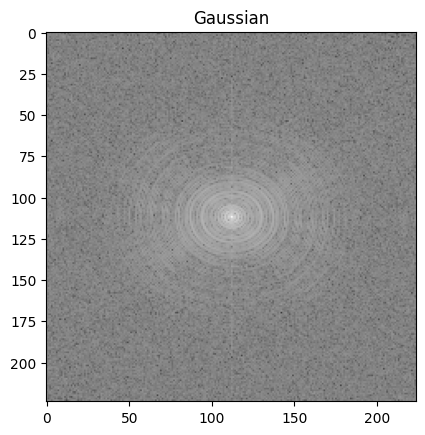

In [9]:
print(all_data['names'][0])
plt.title(CLASSES[all_data['labels'][0]])
plt.imshow(all_data['data'][0])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_data['data'], all_data['labels'], test_size=0.2, random_state=100)

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks for early stopping, model checkpointing, and learning rate reduction
my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
]

## VGG16

In [12]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.layers import Flatten, Dense, MaxPooling2D, Dropout, Conv2D
from keras.models import Model
from keras.losses import CategoricalCrossentropy



# Load pre-trained VGG16 model without the top layers
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze pre-trained layers for fine-tuning later
for layer in pretrained_model.layers:
    layer.trainable = False

x = pretrained_model.output
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create full model
model = Model(inputs=pretrained_model.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [14]:
from keras.utils import to_categorical

history = 0
with tf.device('/GPU:0'):
    history = model.fit(
        x = np.array(X_train),
        y = np.array(to_categorical(y_train)),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(np.array(X_test), np.array(to_categorical(y_test))),
        # validation_steps=5,
        callbacks=my_callbacks
    )

Epoch 1/25
32/32 [==============================] - 30s 663ms/step - loss: 0.4395 - accuracy: 0.8260 - val_loss: 0.1913 - val_accuracy: 0.9240 - lr: 1.0000e-04
Epoch 2/25
32/32 [==============================] - 11s 357ms/step - loss: 0.2115 - accuracy: 0.9140 - val_loss: 0.1430 - val_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 3/25
32/32 [==============================] - 11s 346ms/step - loss: 0.1821 - accuracy: 0.9310 - val_loss: 0.1284 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 4/25
32/32 [==============================] - 9s 297ms/step - loss: 0.1504 - accuracy: 0.9480 - val_loss: 0.1646 - val_accuracy: 0.9360 - lr: 1.0000e-04
Epoch 5/25
32/32 [==============================] - 11s 353ms/step - loss: 0.1329 - accuracy: 0.9580 - val_loss: 0.1000 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 6/25
32/32 [==============================] - 9s 298ms/step - loss: 0.1217 - accuracy: 0.9610 - val_loss: 0.1764 - val_accuracy: 0.9280 - lr: 1.0000e-04
Epoch 7/25
32/32 [========================

In [15]:
predict = np.argmax(model.predict(np.array(X_test)), axis=1)

8/8 [==============================] - 2s 232ms/step


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        76
           1       1.00      1.00      1.00        92
           2       0.93      1.00      0.96        82

    accuracy                           0.98       250
   macro avg       0.98      0.97      0.97       250
weighted avg       0.98      0.98      0.98       250



In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(np.array(X_test), np.array(to_categorical(y_test)))
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
8/8 [==============================] - 2s 232ms/step - loss: 0.0832 - accuracy: 0.9760
Test Accuracy: 97.60000109672546


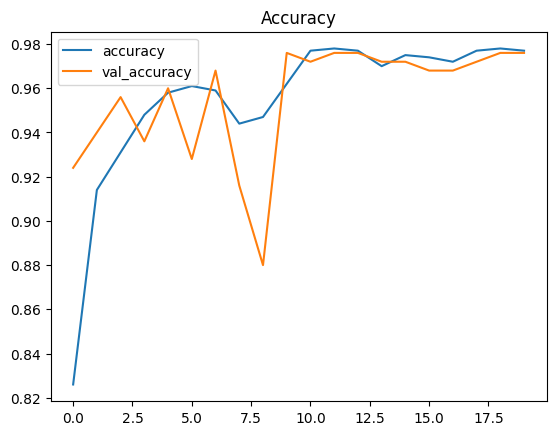

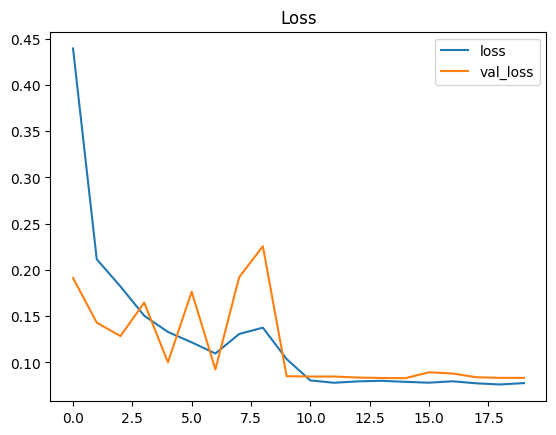

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

1/1 [==============================] - 1s 885ms/step
Periodic


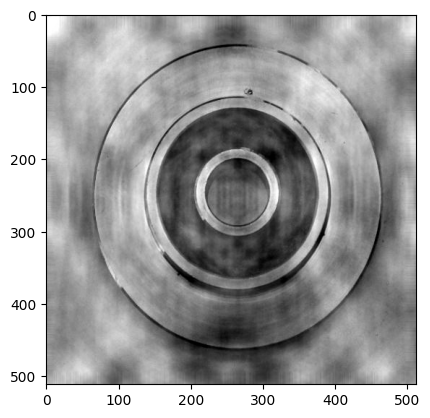

In [19]:
import random

p = data[data['labels']==CLASSES[0]]['images'][data[data['labels']==CLASSES[0]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[0]].__len__()-1)]]
s = data[data['labels']==CLASSES[1]]['images'][data[data['labels']==CLASSES[1]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[1]].__len__()-1)]]
g = data[data['labels']==CLASSES[2]]['images'][data[data['labels']==CLASSES[2]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[2]].__len__()-1)]]

p_result = np.argmax(model.predict([load_test_image(p)]), axis=1)
s_result = np.argmax(model.predict([load_test_image(s)]), axis=1)
g_result = np.argmax(model.predict([load_test_image(g)]), axis=1)

plt_figure(
    [cv2.imread(p),cv2.imread(s),cv2.imread(g)],
    [f'{CLASSES[p_result[0]]}' , f'{CLASSES[s_result[0]]}', f'{CLASSES[g_result[0]]}'], 
    columns=3,
    w=10
    )

In [22]:
model.save('./content/models/VGG16_Noise_Classification_Freq.h5')

## Inception ResNet V2

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions

pretrained_model = InceptionResNetV2(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
from keras.layers import Dense
from keras import Model

x = pretrained_model.output
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)


model = Model(inputs=pretrained_model.input, outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [ ]:
history = 0
with tf.device('/GPU:0'):
    history = model.fit(
        x = np.array(X_train),
        y = np.array(to_categorical(y_train)),
        steps_per_epoch=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(np.array(X_test), np.array(to_categorical(y_test))),
        callbacks=my_callbacks
    )

Epoch 1/25
32/32 [==============================] - 26s 523ms/step - loss: 4.2661 - accuracy: 0.7880 - val_loss: 0.3537 - val_accuracy: 0.9280 - lr: 0.0100
Epoch 2/25
32/32 [==============================] - 11s 343ms/step - loss: 0.2159 - accuracy: 0.9360 - val_loss: 0.1275 - val_accuracy: 0.9400 - lr: 0.0100
Epoch 3/25
32/32 [==============================] - 11s 343ms/step - loss: 0.2165 - accuracy: 0.9380 - val_loss: 0.1380 - val_accuracy: 0.9560 - lr: 0.0100
Epoch 4/25
32/32 [==============================] - 11s 343ms/step - loss: 0.1535 - accuracy: 0.9520 - val_loss: 0.1127 - val_accuracy: 0.9640 - lr: 0.0100
Epoch 5/25
32/32 [==============================] - 11s 343ms/step - loss: 0.1167 - accuracy: 0.9600 - val_loss: 0.1390 - val_accuracy: 0.9600 - lr: 0.0100
Epoch 6/25
32/32 [==============================] - 11s 343ms/step - loss: 0.1227 - accuracy: 0.9570 - val_loss: 0.1577 - val_accuracy: 0.9480 - lr: 0.0100
Epoch 7/25
32/32 [==============================] - 11s 344ms/st

In [ ]:
predict = np.int8(np.argmax(model.predict(np.array(X_test)), axis=1))

8/8 [==============================] - 5s 279ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94        76
           1       0.99      1.00      0.99        92
           2       0.92      0.99      0.95        82

    accuracy                           0.96       250
   macro avg       0.97      0.96      0.96       250
weighted avg       0.97      0.96      0.96       250



In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(np.array(X_test), np.array(to_categorical(y_test)))
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
8/8 [==============================] - 2s 271ms/step - loss: 0.0998 - accuracy: 0.9640
Test Accuracy: 96.39999866485596


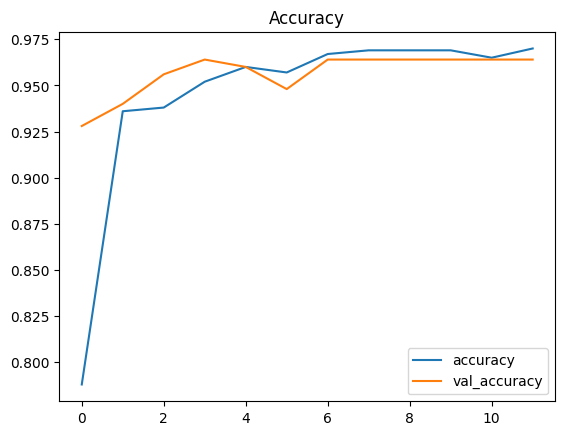

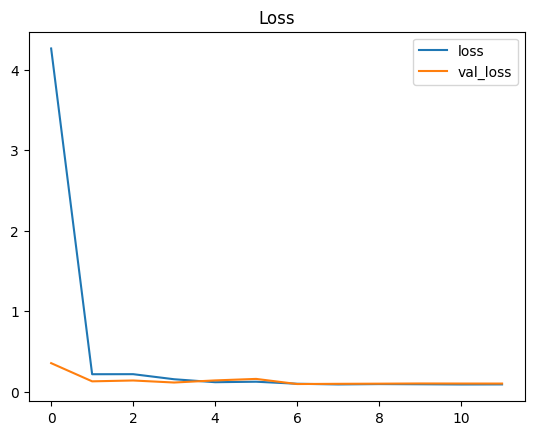

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
import random

p = data[data['labels']==CLASSES[0]]['images'][data[data['labels']==CLASSES[0]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[0]].__len__()-1)]]
s = data[data['labels']==CLASSES[1]]['images'][data[data['labels']==CLASSES[1]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[1]].__len__()-1)]]
g = data[data['labels']==CLASSES[2]]['images'][data[data['labels']==CLASSES[2]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[2]].__len__()-1)]]

p_result = np.argmax(model.predict([load_test_image(p)]), axis=1)
s_result = np.argmax(model.predict([load_test_image(s)]), axis=1)
g_result = np.argmax(model.predict([load_test_image(g)]), axis=1)

plt_figure(
    [cv2.imread(p),cv2.imread(s),cv2.imread(g)],
    [f'{CLASSES[p_result[0]]}' , f'{CLASSES[s_result[0]]}', f'{CLASSES[g_result[0]]}'], 
    columns=3,
    w=10
    )

In [ ]:
model.save('./content/models/InceptionResNetV2_Noise_Classification_Freq.h5')

1/1 [==============================] - 0s 17ms/step
Periodic


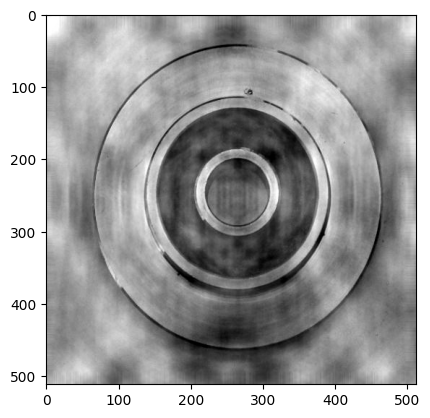

In [23]:
import random

p = data[data['labels']==CLASSES[0]]['images'][data[data['labels']==CLASSES[0]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[0]].__len__()-1)]]
s = data[data['labels']==CLASSES[1]]['images'][data[data['labels']==CLASSES[1]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[1]].__len__()-1)]]
g = data[data['labels']==CLASSES[2]]['images'][data[data['labels']==CLASSES[2]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[2]].__len__()-1)]]

p_result = np.argmax(model.predict([load_test_image(p)]), axis=1)
s_result = np.argmax(model.predict([load_test_image(s)]), axis=1)
g_result = np.argmax(model.predict([load_test_image(g)]), axis=1)

plt_figure(
    [cv2.imread(p),cv2.imread(s),cv2.imread(g)],
    [f'{CLASSES[p_result[0]]}' , f'{CLASSES[s_result[0]]}', f'{CLASSES[g_result[0]]}'], 
    columns=3,
    w=10
    )